In [ ]:
#Training efnet

In [ ]:
path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images'
json_path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\annotations'
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.nn import functional
import json
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder
from pandas import get_dummies

bsize=256

img_names = os.listdir(path)
img_names = [k for k in img_names if 'npy' not in k]
i=0
from sklearn.model_selection import train_test_split
train, test = train_test_split(img_names, test_size=0.8, random_state=5)

images = np.empty(shape = (bsize, 3, 256, 256))
labels = np.chararray(bsize, itemsize=20)

In [ ]:
train_y = train.copy()
train_X = train.copy()
for i in range(len(train)):
    train_X[i] = path + '\\' + img_names[i]
    train_y[i] = json_path + '\\' + img_names[i]
    train_y[i] = train_y[i].replace(train_y[i][len(train_y[i]) - 3:], 'json')

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [ ]:
class MyDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        f = open(self.label_paths[index])
        data = json.load(f)
        t = data['chart-type']
        #print(t)
        if (t=='scatter'):
            label = 0
        elif (t=='vertical_bar'):
            label = 1
        elif (t=='dot'):
            label = 2
        elif (t=='horizontal_bar'):
            label = 3
        else:
            label = 4
        f.close()
        
        if self.transform:
            image = self.transform(image)
            #label = self.transform(label)
            
        return image, label

# Define the transform to resize and normalize the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create a dataset from the image and label file paths
dataset = MyDataset(train_X, train_y, transform=transform)

# Create a dataloader to load the data in batches
batch_size = 256
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
efnet_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
efnet_model = torchvision.models.efficientnet_b0(weights = efnet_weights)
## Loop through each parameter and set `requires_grad` to false
for param in efnet_model.features.parameters():
    param.requires_grad = False

## Replace the "classifier" layer with one for our application
efnet_model.classifier = torch.nn.Sequential( 
    torch.nn.Linear(in_features=1280, out_features=5, bias=True))

In [ ]:
from torch import nn
epochs = 25
lrate = 0.1
cost_fn = nn.NLLLoss()
net = efnet_model
optimizer = torch.optim.Adam(net.parameters(), lr=lrate)
track_cost = np.zeros(epochs)

for epoch in range(epochs):
    cur_cost = 0.0
    correct = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        inputs = inputs.reshape(inputs.size())
        outputs = net(inputs)
        #print(labels)
        
        cost = cost_fn(outputs.log_softmax(dim=1), labels)
        cost.backward()
        optimizer.step()
        cur_cost += cost.item()
        
    track_cost[epoch] = cur_cost
    print(f"Epoch: {epoch} Cost: {cur_cost}")

In [ ]:
#ADD TEST CODE TO MAKE SURE IT WORKS
test_y = test.copy()
test_X = test.copy()
i=0
for i in range(len(test)):
    test_X[i] = path + '\\' + img_names[i]
    test_y[i] = json_path + '\\' + img_names[i]
    test_y[i] = test_y[i].replace(test_y[i][len(test_y[i]) - 3:], 'json')

In [ ]:
dataset = MyDataset(test_X, test_y, transform=transform)

# Create a dataloader to load the data in batches
batch_size = 256
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# set model to evaluation mode
net.eval()

# iterate through test data and generate predictions
with torch.no_grad():
    predicted = []
    actual = []
    for data in test_loader:
        inputs, labels = data
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        predicted.append(pred.numpy())
        actual.append(labels.numpy())
        #print(pred)
        #print(labels)
        #if (pred != labels):
            #print(inputs)

# concatenate predicted and actual labels
predicted = np.concatenate(predicted)
actual = np.concatenate(actual)

# compute accuracy
accuracy = np.mean(predicted == actual)
print(accuracy)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(actual, predicted)

In [ ]:
#CNN MODEL

In [ ]:
from torch import nn

class my_net(nn.Module):
    
    ## Constructor commands
    def __init__(self):
        super(my_net, self).__init__()
        
        ## Define architecture
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3,10,4,2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(10,30,2,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(28830, 250),
            nn.ReLU(),
            nn.Linear(250, 5)
        )
    
    ## Function to generate predictions
    def forward(self, x):
        scores = self.conv_stack(x)
        return scores

In [ ]:
## Hyperparms
#epochs = 300
lrate = 0.025
bsize = 100

## For reproduction purposes 
torch.manual_seed(7)

## Cost Function
cost_fn = nn.CrossEntropyLoss()

## Intialize the model
net = my_net()

## Optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(net.parameters(), lr=lrate)

In [ ]:
img_names = os.listdir(path)
img_names = [k for k in img_names if 'npy' not in k]
i=0
from sklearn.model_selection import train_test_split
train, test = train_test_split(img_names, test_size=0.9, random_state=5)

images = np.empty(shape = (bsize, 3, 256, 256))
labels = np.chararray(bsize, itemsize=20)

In [ ]:
train_y = train.copy()
train_X = train.copy()
for i in range(len(train)):
    train_X[i] = path + '\\' + img_names[i]
    train_y[i] = json_path + '\\' + img_names[i]
    train_y[i] = train_y[i].replace(train_y[i][len(train_y[i]) - 3:], 'json')

In [ ]:
class MyDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        f = open(self.label_paths[index])
        data = json.load(f)
        t = data['chart-type']
        #print(t)
        if (t=='scatter'):
            label = 0
        elif (t=='vertical_bar'):
            label = 1
        elif (t=='dot'):
            label = 2
        elif (t=='horizontal_bar'):
            label = 3
        else:
            label = 4
        f.close()
        
        if self.transform:
            image = self.transform(image)
            #label = self.transform(label)
            
        return image, label

# Define the transform to resize and normalize the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create a dataset from the image and label file paths
dataset = MyDataset(train_X, train_y, transform=transform)

# Create a dataloader to load the data in batches
batch_size = 256
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
## Initial values for cost tracking
epochs = 25
track_cost = np.zeros(epochs)
cur_cost = 0.0

## Loop through the data
for epoch in range(epochs):
    
    cur_cost = 0.0
    correct = 0.0
    
    ## train_loader is iterable and numbers knows the batch
    for i, data in enumerate(train_loader, 0):
        
        ## The input tensor and labels tensor for the current batch
        inputs, labels = data
        
        ## Clear the gradient from the previous batch
        optimizer.zero_grad()
        
        ## Provide the input tensor into the network to get outputs
        outputs = net(inputs)
        
        ## Calculate the cost for the current batch
        ## nn.Softmax is used because net outputs prediction scores and our cost function expects probabilities and labels
        cost = cost_fn(nn.Softmax(dim=1)(outputs), labels)
        
        ## Calculate the gradient
        cost.backward()
        
        ## Update the model parameters using the gradient
        optimizer.step()
        
        ## Track the current cost (accumulating across batches)
        cur_cost += cost.item()
    
    ## Store the accumulated cost at each epoch
    track_cost[epoch] = cur_cost
    print(f"Epoch: {epoch} Cost: {cur_cost}") ## Uncomment this if you want printed updates

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0, epochs, epochs), track_cost)
plt.show()

In [ ]:
#ADD TEST CODE TO MAKE SURE IT WORKS
test_y = test.copy()
test_X = test.copy()
i=0
for i in range(len(test)):
    test_X[i] = path + '\\' + img_names[i]
    test_y[i] = json_path + '\\' + img_names[i]
    test_y[i] = test_y[i].replace(test_y[i][len(test_y[i]) - 3:], 'json')

In [ ]:
dataset = MyDataset(test_X, test_y, transform=transform)

# Create a dataloader to load the data in batches
batch_size = 256
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Repeat evaluation loop using the test data
correct = 0
total = 0
actual = np.empty(0, dtype=int)
predict = np.empty(0, dtype=int)
with torch.no_grad():
    for data in test_loader:
        #if (not total % 100):
            #print(total)
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #print(labels.numpy())
        #print(predicted.numpy())
        actual = np.append(actual, labels.numpy())
        predict = np.append(predict, predicted.numpy())
        #print(actual)
        #print(predict)
        
print(correct/total)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(actual, predict)

In [ ]:
#Attention Model

In [1]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
image_path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images'
dir_Flickr_text = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\text'
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))
ann = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\annotations'

Total Images in Dataset = 120338


In [3]:
import json
image_path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images'
l = os.listdir(image_path)
datas = []
result = ""
i=0

for filename in l:
    file_name = "info.txt"
    #print(file_name)
    if filename.endswith('.jpg'):
        info = []
        image_path = os.path.join(filename)
        txt_path = os.path.join(dir_Flickr_text, "info.txt")
        j = ann + '\\' + filename
        j = j[:-3] + 'json'
        with open(j, encoding="utf-8") as f:
            data = json.load(f)
            #print(data)
        f.close()
        result += image_path + "#" + str(i) + "\t"
        # Create the file in the specified directory and write the text to it
        #print(data)
        #file_text = data['text'][0]['text']
        file_text = data['chart-type'] + " " + data['chart-type'] + "a" + " " + data['chart-type'] + "b" + " " + data['chart-type'] + "c"
        #print(file_text)
        result += file_text
        result = result + "\n"
        i+=1
with open(txt_path, 'w', encoding="utf-8") as f:
    f.write(result)
#datas.append({'image_path': image_path, 'label': txt_path})

In [4]:
file = open(os.path.join(dir_Flickr_text, "info.txt"),'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split('\t')
   if len(col) == 1:
       continue
   w = col[0].split("#")
   datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

,index,filename,caption
0,0,0003a50817cf.jpg,line linea lineb linec
1,1,0005413054c9.jpg,line linea lineb linec
2,2,0005e64fdc6e.jpg,scatter scattera scatterb scatterc
3,3,000614d3eab6.jpg,line linea lineb linec
4,4,000631f33080.jpg,scatter scattera scatterb scatterc


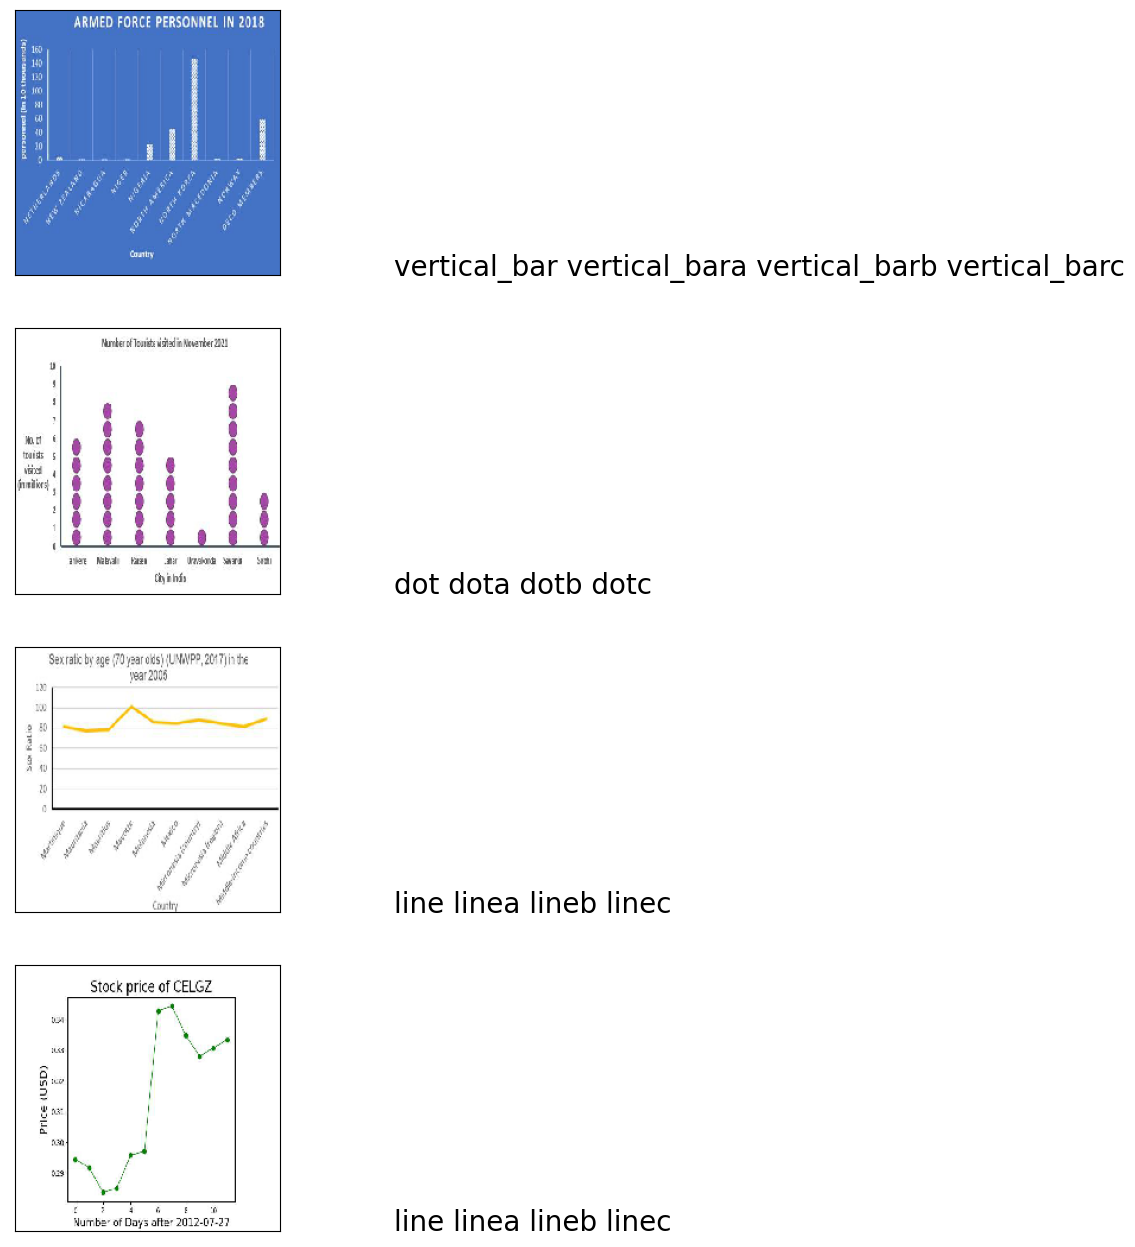

In [5]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1
image_path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images'

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
   filename = image_path + '\\' + jpgfnm
   captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

In [6]:
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 20


In [7]:
for i, caption in enumerate(data.caption.values):
   data["caption"].iloc[i] = caption

clean_vocabulary = set(vocabulary)
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 20


In [8]:
PATH = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images'
all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:50]

['<start> line linea lineb linec <end>',
 '<start> line linea lineb linec <end>',
 '<start> scatter scattera scatterb scatterc <end>',
 '<start> line linea lineb linec <end>',
 '<start> scatter scattera scatterb scatterc <end>',
 '<start> dot dota dotb dotc <end>',
 '<start> dot dota dotb dotc <end>',
 '<start> vertical_bar vertical_bara vertical_barb vertical_barc <end>',
 '<start> line linea lineb linec <end>',
 '<start> line linea lineb linec <end>',
 '<start> vertical_bar vertical_bara vertical_barb vertical_barc <end>',
 '<start> dot dota dotb dotc <end>',
 '<start> line linea lineb linec <end>',
 '<start> line linea lineb linec <end>',
 '<start> line linea lineb linec <end>',
 '<start> scatter scattera scatterb scatterc <end>',
 '<start> line linea lineb linec <end>',
 '<start> line linea lineb linec <end>',
 '<start> vertical_bar vertical_bara vertical_barb vertical_barc <end>',
 '<start> line linea lineb linec <end>',
 '<start> vertical_bar vertical_bara vertical_barb vertical_

In [9]:
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + "\\" + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\0003a50817cf.jpg',
 'C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\0005413054c9.jpg',
 'C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\0005e64fdc6e.jpg',
 'C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\000614d3eab6.jpg',
 'C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\000631f33080.jpg',
 'C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\000917f5d829.jpg',
 'C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\000944919c5c.jpg',
 'C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\0011bb0573da.jpg',
 'C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\001221641993.jpg',
 'C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\001228841945.jpg']

In [10]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 60338
len(all_captions) : 60338


In [11]:
def data_limiter(num,total_captions,all_img_name_vector):
    train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
    train_captions = train_captions[:num]
    img_name_vector = img_name_vector[:num]
    return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(60000,all_captions,all_img_name_vector)

In [12]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [13]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [14]:
%%time
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 938/938 [1:16:48<00:00,  4.91s/it]

Wall time: 1h 16min 48s


In [15]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [16]:
train_captions[:3]

['<start> line linea lineb linec <end>',
 '<start> scatter scattera scatterb scatterc <end>',
 '<start> line linea lineb linec <end>']

In [17]:
train_seqs[:3]

[[2, 4, 5, 6, 7, 3], [2, 12, 13, 14, 15, 3], [2, 4, 5, 6, 7, 3]]

In [18]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 6 : 6


In [19]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.5, random_state=0)

In [20]:
BATCH_SIZE = 24
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [21]:
def map_func(img_name, cap):
 img_tensor = np.load(img_name.decode('utf-8')+'.npy')
 return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [22]:
class VGG16_Encoder(tf.keras.Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(VGG16_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x   

In [23]:
def rnn_type(units):
   if tf.test.is_gpu_available():
       return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
   else:
       return tf.keras.layers.GRU(units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_activation='sigmoid',
                                  recurrent_initializer='glorot_uniform')

In [24]:
class Rnn_Local_Decoder(tf.keras.Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
   self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  
   self.fc1 = tf.keras.layers.Dense(self.units)

   self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = tf.keras.layers.Dense(vocab_size)

   # Implementing Attention Mechanism
   self.Uattn = tf.keras.layers.Dense(units)
   self.Wattn = tf.keras.layers.Dense(units)
   self.Vattn = tf.keras.layers.Dense(1)

 def call(self, x, features, hidden):
   # features shape ==> (64,49,256) ==> Output from ENCODER
   # hidden shape == (batch_size, hidden_size) ==>(64,512)
   # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

   hidden_with_time_axis = tf.expand_dims(hidden, 1)

   # score shape == (64, 49, 1)
   # Attention Function
   '''e(ij) = f(s(t-1),h(j))'''
   ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

   # self.Uattn(features) : (64,49,512)
   # self.Wattn(hidden_with_time_axis) : (64,1,512)
   # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
   # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

   # you get 1 at the last axis because you are applying score to self.Vattn
   # Then find Probability using Softmax
   '''attention_weights(alpha(ij)) = softmax(e(ij))'''

   attention_weights = tf.nn.softmax(score, axis=1)

   # attention_weights shape == (64, 49, 1)
   # Give weights to the different pixels in the image
   ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''

   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)

   # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
   # context_vector shape after sum == (64, 256)
   # x shape after passing through embedding == (64, 1, 256)

   x = self.embedding(x)
   # x shape after concatenation == (64, 1,  512)

   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
   # passing the concatenated vector to the GRU

   output, state = self.gru(x)
   # shape == (batch_size, max_length, hidden_size)

   x = self.fc1(output)
   # x shape == (batch_size * max_length, hidden_size)

   x = tf.reshape(x, (-1, x.shape[2]))

   # Adding Dropout and BatchNorm Layers
   x= self.dropout(x)
   x= self.batchnormalization(x)

   # output shape == (64 * 512)
   x = self.fc2(x)

   # shape : (64 * 8329(vocab))
   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))


encoder = VGG16_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [25]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

In [26]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
 loss = 0
 # initializing the hidden state for each batch
 # because the captions are not related from image to image

 hidden = decoder.reset_state(batch_size=target.shape[0])
 dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

 with tf.GradientTape() as tape:
     features = encoder(img_tensor)
     for i in range(1, target.shape[1]):
         # passing the features through the decoder
         predictions, hidden, _ = decoder(dec_input, features, hidden)
         loss += loss_function(target[:, i], predictions)

         # using teacher forcing
         dec_input = tf.expand_dims(target[:, i], 1)

 total_loss = (loss / int(target.shape[1]))
 trainable_variables = encoder.trainable_variables + decoder.trainable_variables
 gradients = tape.gradient(loss, trainable_variables)
 optimizer.apply_gradients(zip(gradients, trainable_variables))

 return loss, total_loss

In [27]:
EPOCHS = 20
start_epoch = 0
for epoch in range(start_epoch, EPOCHS):
   start = time.time()
   total_loss = 0

   for (batch, (img_tensor, target)) in enumerate(dataset):
       batch_loss, t_loss = train_step(img_tensor, target)
       total_loss += t_loss

       if batch % 100 == 0:
           print ('Epoch {} Batch {} Loss {:.4f}'.format(
             epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
   # storing the epoch end loss value to plot later
   loss_plot.append(total_loss / num_steps)

   print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss/num_steps))

   print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.8824
Epoch 1 Batch 100 Loss 0.0696
Epoch 1 Batch 200 Loss 0.0007
Epoch 1 Batch 300 Loss 0.0006
Epoch 1 Batch 400 Loss 0.0263
Epoch 1 Batch 500 Loss 0.0217
Epoch 1 Batch 600 Loss 0.0001
Epoch 1 Batch 700 Loss 0.0008
Epoch 1 Batch 800 Loss 0.0001
Epoch 1 Batch 900 Loss 0.0115
Epoch 1 Batch 1000 Loss 0.0078
Epoch 1 Batch 1100 Loss 0.0072
Epoch 1 Batch 1200 Loss 0.0000
Epoch 1 Loss 0.064117
Time taken for 1 epoch 100.36696910858154 sec

Epoch 2 Batch 0 Loss 0.0009
Epoch 2 Batch 100 Loss 0.0001
Epoch 2 Batch 200 Loss 0.0000
Epoch 2 Batch 300 Loss 0.0001
Epoch 2 Batch 400 Loss 0.0003
Epoch 2 Batch 500 Loss 0.0026
Epoch 2 Batch 600 Loss 0.0000
Epoch 2 Batch 700 Loss 0.0001
Epoch 2 Batch 800 Loss 0.0001
Epoch 2 Batch 900 Loss 0.0000
Epoch 2 Batch 1000 Loss 0.0000
Epoch 2 Batch 1100 Loss 0.0005
Epoch 2 Batch 1200 Loss 0.0001
Epoch 2 Loss 0.002457
Time taken for 1 epoch 86.98225522041321 sec

Epoch 3 Batch 0 Loss 0.0000
Epoch 3 Batch 100 Loss 0.0000
Epoch 3 Batch 200 Loss 

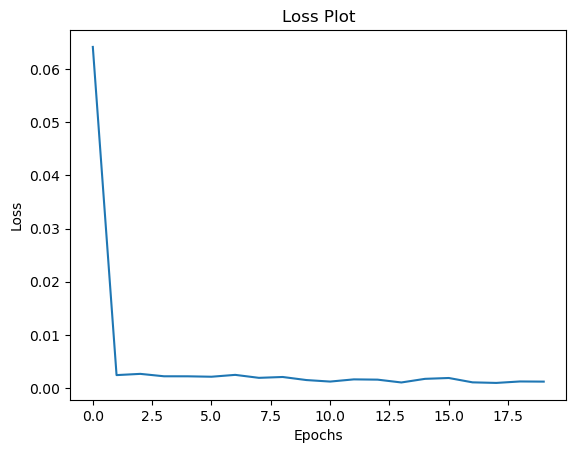

In [28]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [29]:
def evaluate(image):
   attention_plot = np.zeros((max_length, attention_features_shape))

   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []

   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           return result, attention_plot

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]

   return result, attention_plot

In [30]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    #print(result)
    #print(len(result))
    for l in range(1, len_result-1):
        #print(l)
        temp_att = np.resize(attention_plot[l], (8, 8))
        #print("hello" + str(l))
        ax = fig.add_subplot(len_result//2, len_result//2, l)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

BELU score: 8.38826642100846e-153
Real Caption: scatter scattera
Prediction Caption: scatter scattera scatterb scatterc


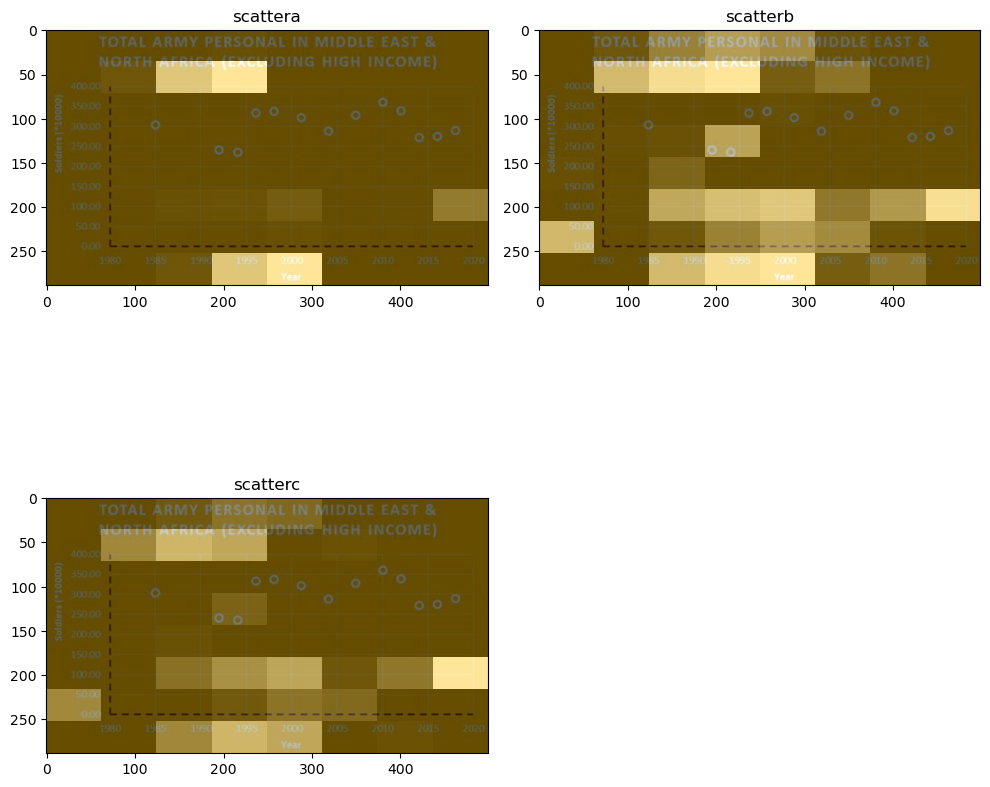

In [31]:
rid = np.random.randint(0, len(img_name_val))
image = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\ffba62c94141.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
real_caption = 'scatter scattera'
first = real_caption.split(' ', 1)[1]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

BELU score: 8.38826642100846e-153
Real Caption: line linea
Prediction Caption: line linea lineb linec


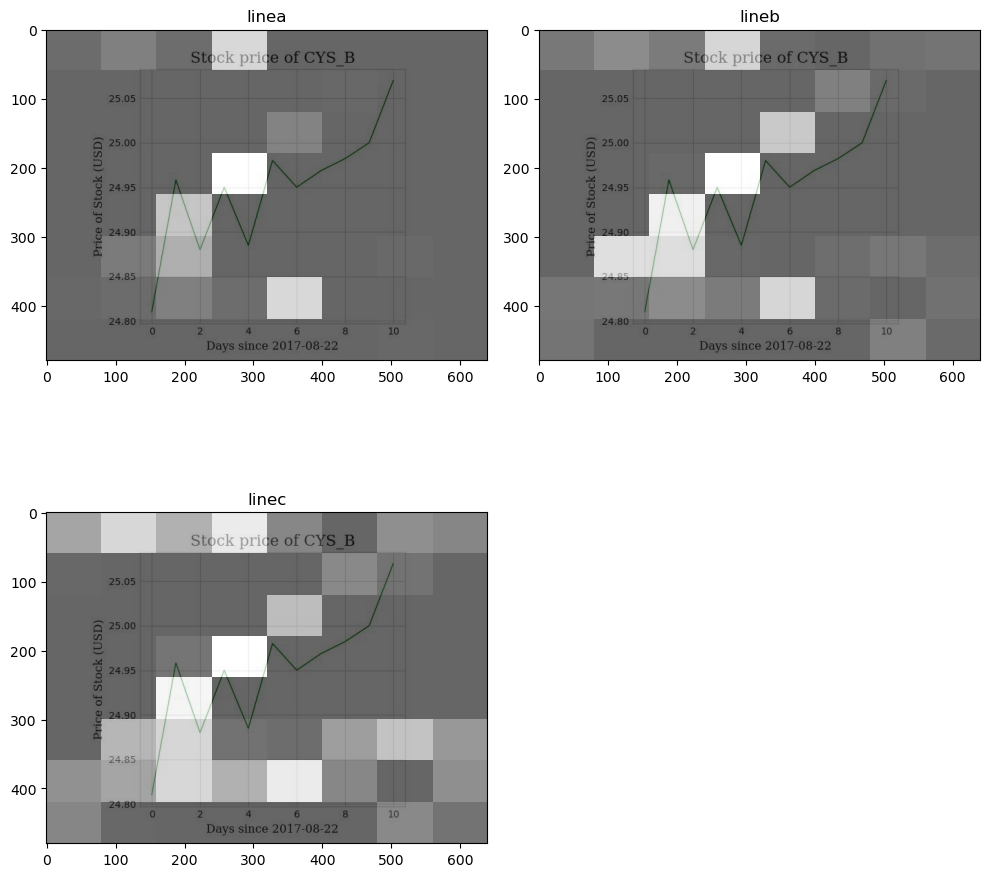

In [32]:
rid = np.random.randint(0, len(img_name_val))
image = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\30a4e658c99b.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
real_caption = 'line linea'
first = real_caption.split(' ', 1)[1]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

BELU score: 8.38826642100846e-153
Real Caption: line linea
Prediction Caption: line linea lineb linec


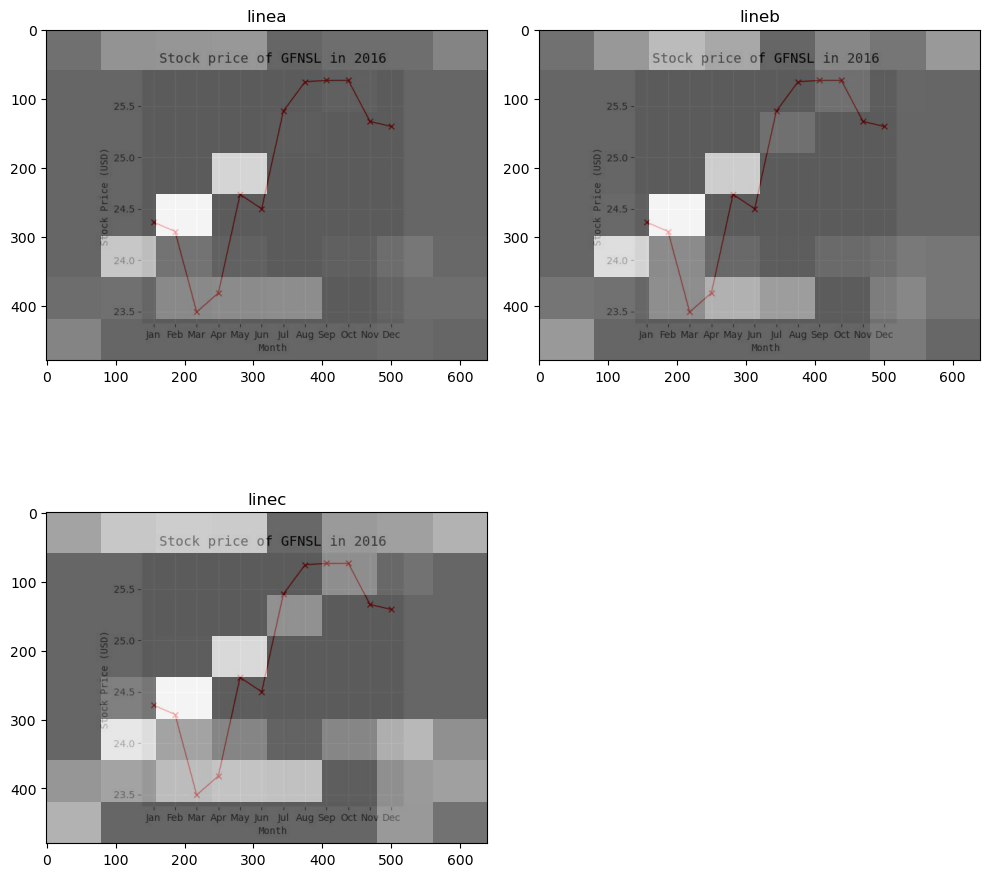

In [33]:
rid = np.random.randint(0, len(img_name_val))
image = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\869d37426a45.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
real_caption = 'line linea'
first = real_caption.split(' ', 1)[1]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

BELU score: 66.8740304976422
Real Caption: scatter scattera scatterb scatterc
Prediction Caption: scatter scattera scatterb scatterc


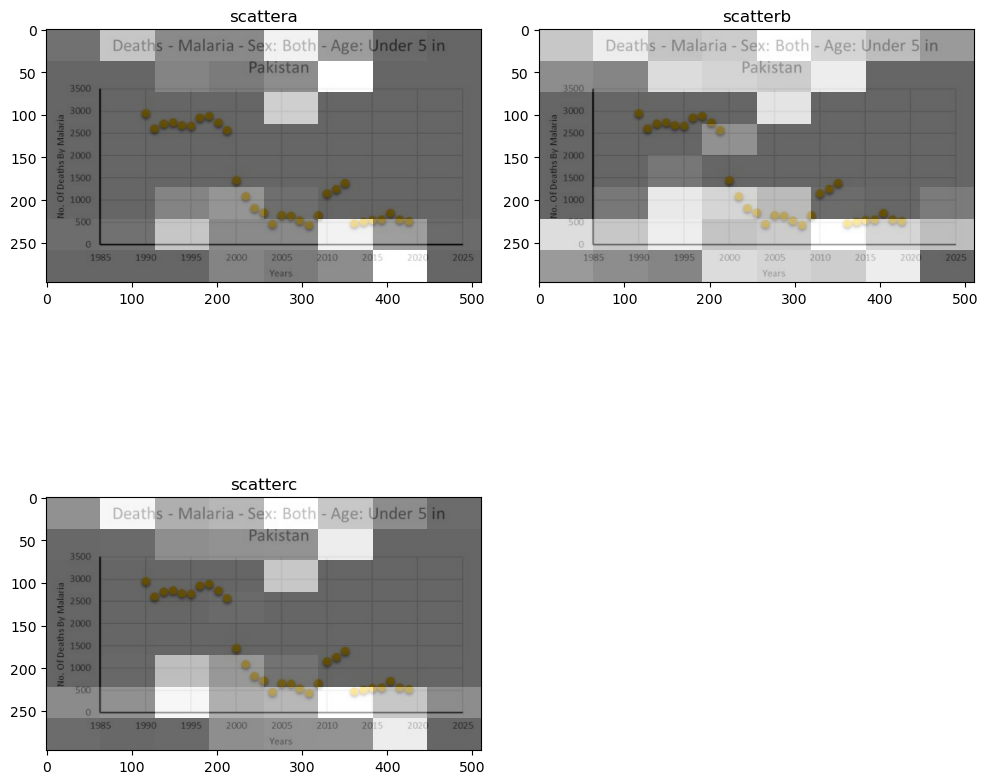

In [34]:
rid = np.random.randint(0, len(img_name_val))
image = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\d7e90a8b9f9a.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
real_caption = 'scatter scattera scatterb scatterc'
first = real_caption.split(' ', 1)[1]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

BELU score: 0
Real Caption: dot dota dotb dotc
Prediction Caption: line linea lineb linec


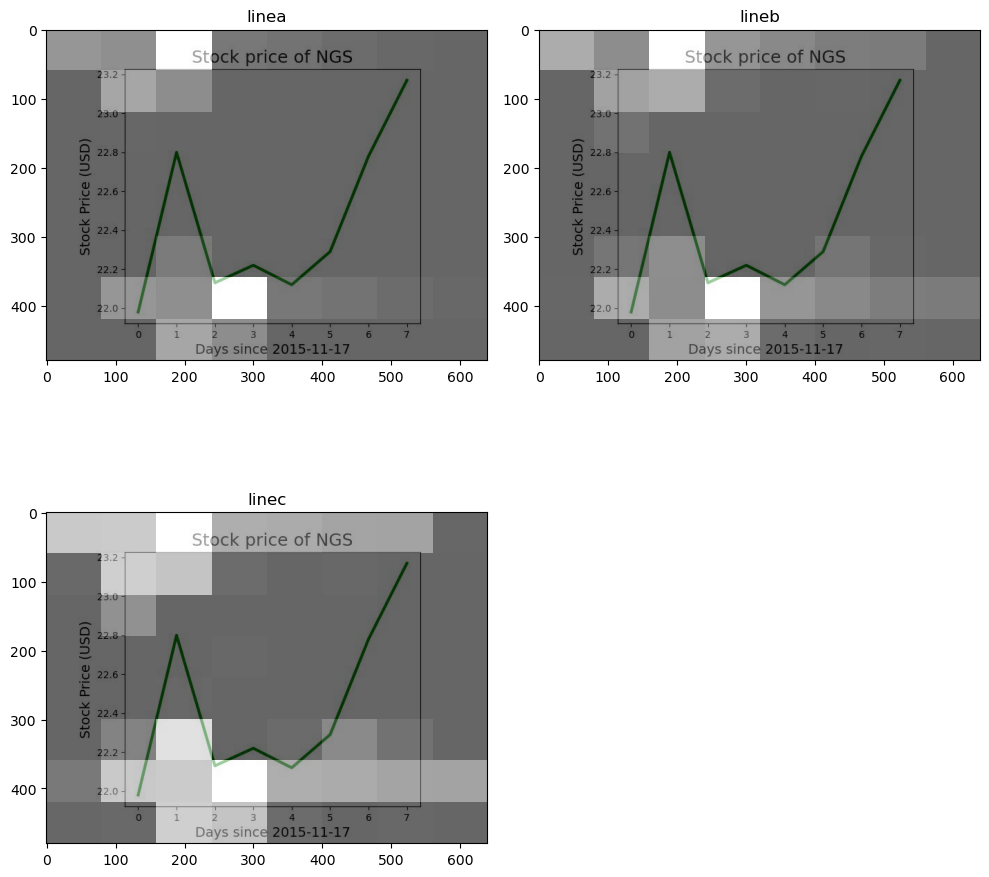

In [35]:
rid = np.random.randint(0, len(img_name_val))
image = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\d81d1c2dc898.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
real_caption = 'dot dota dotb dotc'
first = real_caption.split(' ', 1)[1]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

In [36]:
#new plots

BELU score: 66.8740304976422
Real Caption: horizontal_bar horizontal_bara horizontal_barb horizontal_barc
Prediction Caption: horizontal_bar horizontal_bara horizontal_barb horizontal_barc


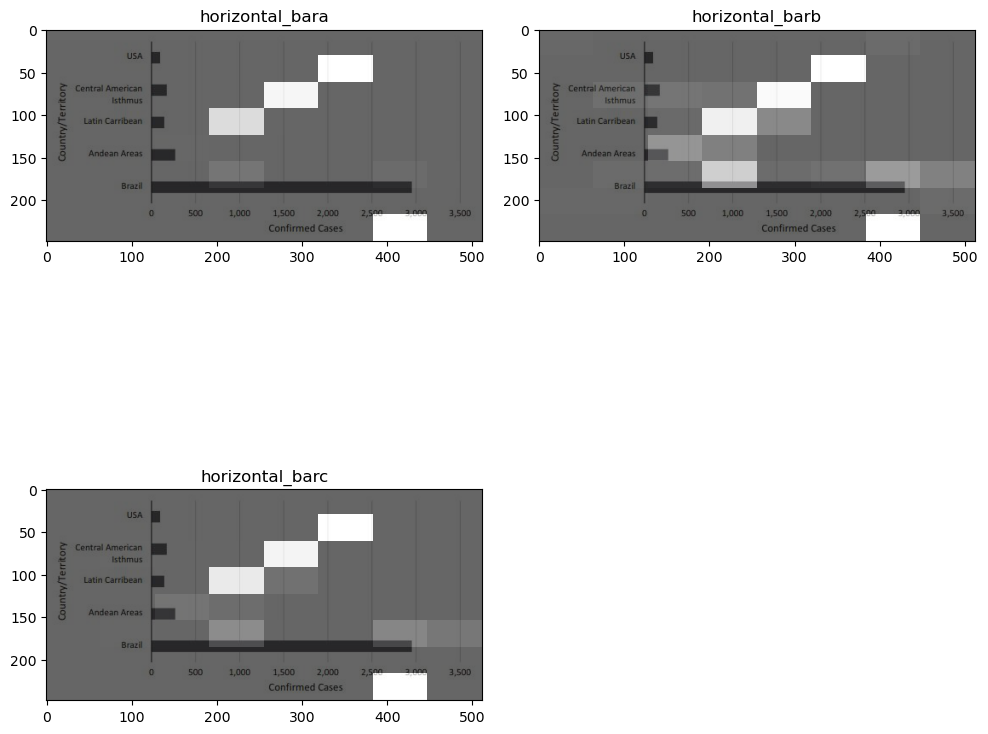

In [37]:
rid = np.random.randint(0, len(img_name_val))
image = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\09874dc0e2fe.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
real_caption = 'horizontal_bar horizontal_bara horizontal_barb horizontal_barc'
first = real_caption.split(' ', 1)[1]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

BELU score: 66.8740304976422
Real Caption: vertical_bar vertical_bara vertical_barb vertical_barc
Prediction Caption: vertical_bar vertical_bara vertical_barb vertical_barc


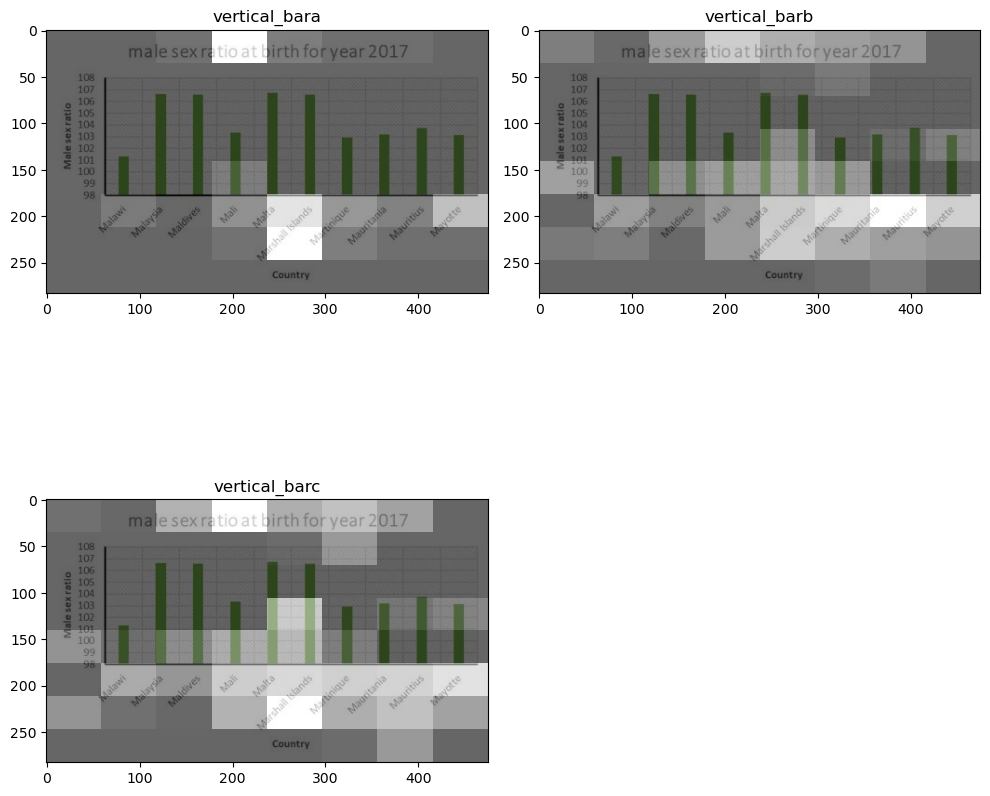

In [38]:
rid = np.random.randint(0, len(img_name_val))
image = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\098a407bc96c.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
real_caption = 'vertical_bar vertical_bara vertical_barb vertical_barc'
first = real_caption.split(' ', 1)[1]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

BELU score: 66.8740304976422
Real Caption: dot dota dotb dotc
Prediction Caption: dot dota dotb dotc


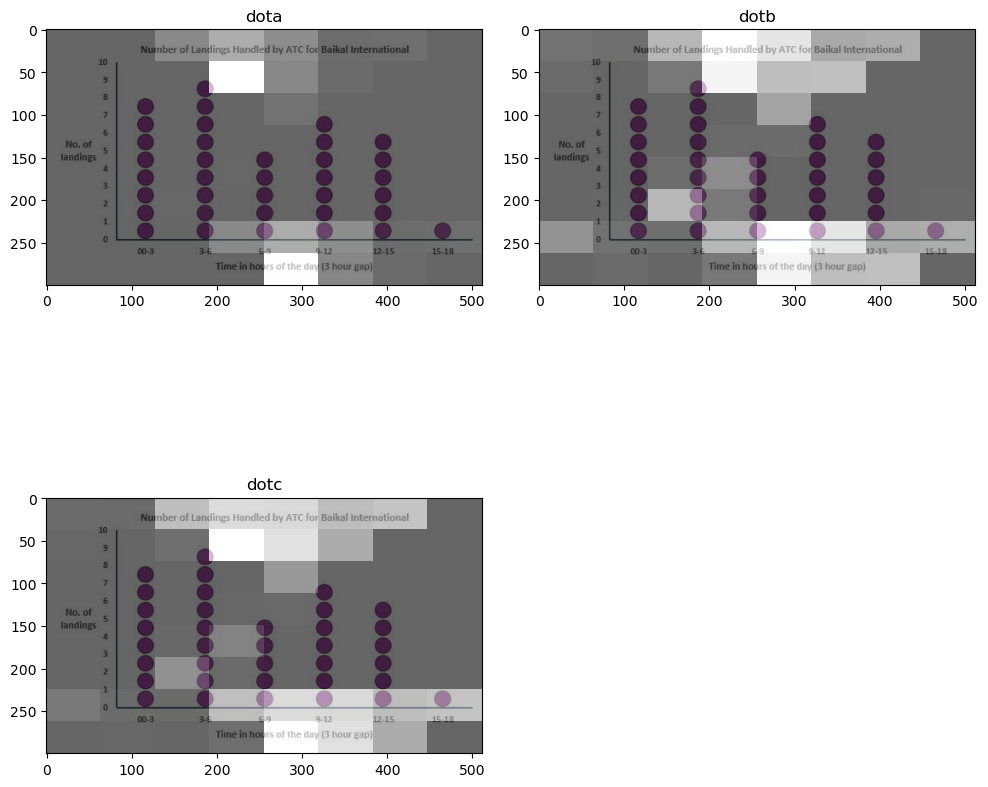

In [39]:
rid = np.random.randint(0, len(img_name_val))
image = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\098ad3abe9c7.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
real_caption = 'dot dota dotb dotc'
first = real_caption.split(' ', 1)[1]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

BELU score: 0
Real Caption: dot dota dotb dotc
Prediction Caption: scatter scattera scatterb scatterc


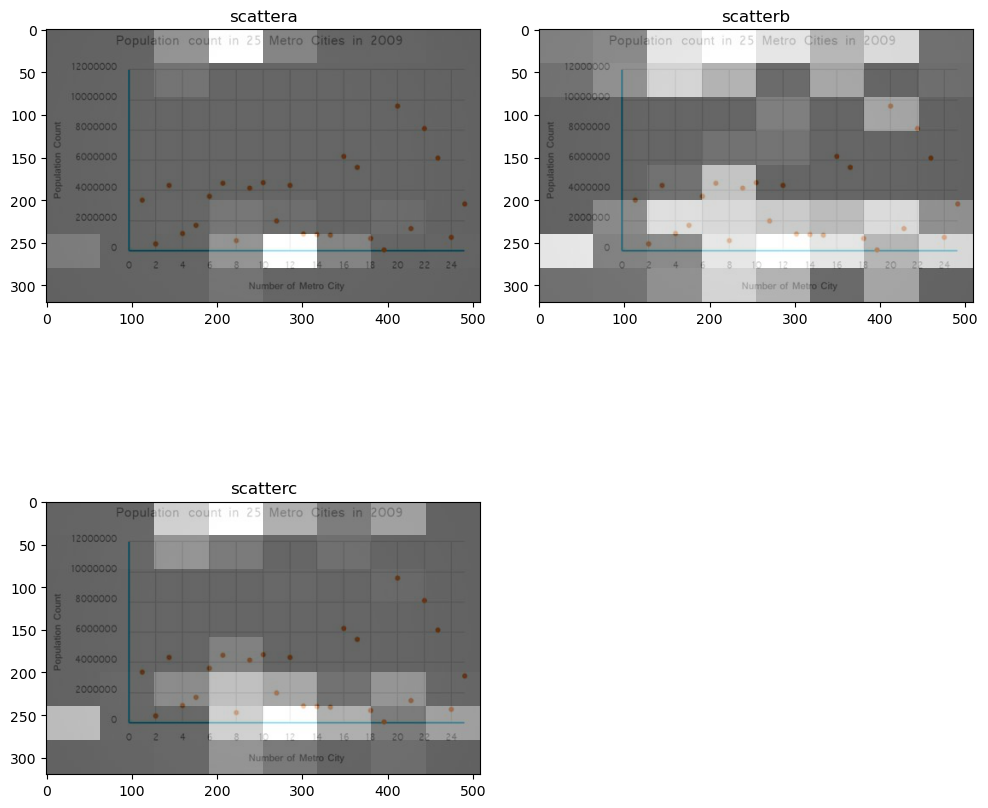

In [40]:
rid = np.random.randint(0, len(img_name_val))
image = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\098cdacf81c8.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
real_caption = 'dot dota dotb dotc'
first = real_caption.split(' ', 1)[1]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

BELU score: 66.8740304976422
Real Caption: line linea lineb linec
Prediction Caption: line linea lineb linec


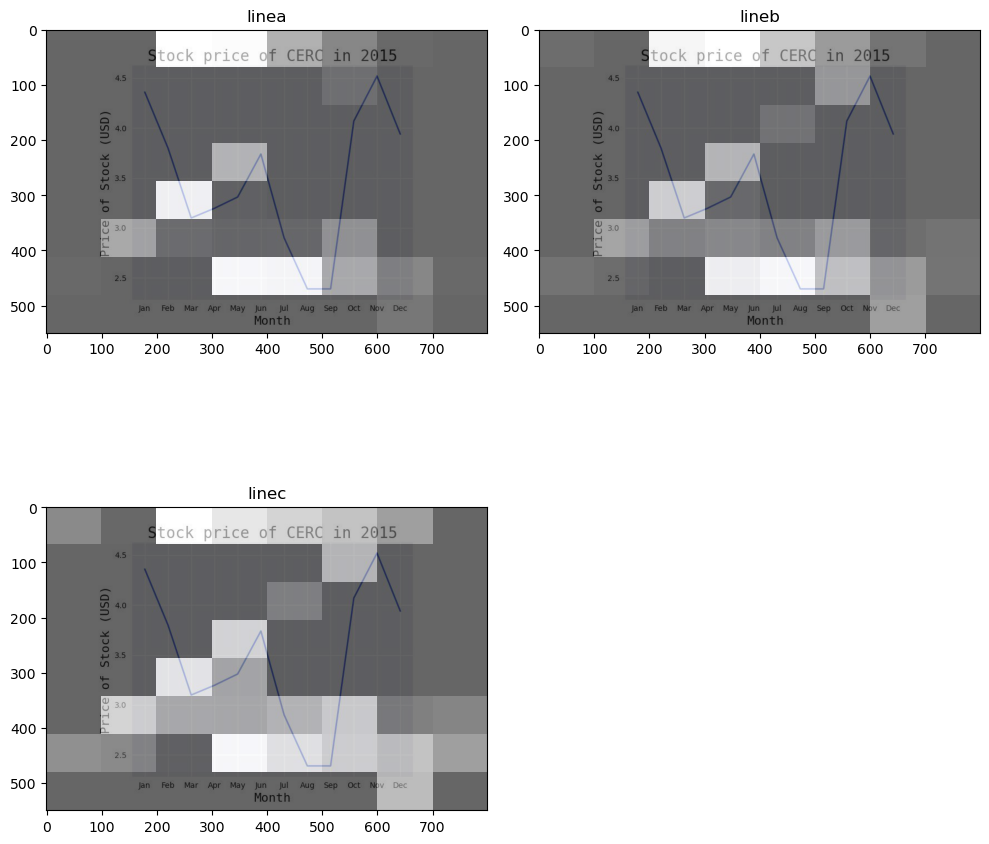

In [44]:
rid = np.random.randint(0, len(img_name_val))
image = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\000614d3eab6.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
real_caption = 'line linea lineb linec'
first = real_caption.split(' ', 1)[1]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)